In [1]:
# pixel-CNN with mixture or softmax

In [2]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# read dataset (MNIST)
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
height, width, channel = 28, 28, 1
number_train = 60000
number_test = 10000

C:\Users\Asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# define structural parameters:

# convolution layers
hidden_dims = 16
recurrent_length = 7
out_hidden_dims = 32
out_recurrent_length = 2


# parameters of sigmoid or softmax
COLOR = 1   # number of colors (mnist)
OUT = COLOR # pixel_CNN with softmax layer


# training parameters
batch_size = 2
max_epoch = 12000
learning_rate = 0.0001
train_step = 2    # number_train // batch_size
test_step = 1       # number_test // batch_size

# parameter of generation
number_generate = 5   # number of generating images
height_occlud = height // 2

In [5]:
# define weights and biases

X = tf.placeholder(tf.float32,[None,784])        # define input
x = tf.reshape(X, [-1, height, width, channel])  # reshape input

# normalization of input: for cifar10, ...
# x = (x - tf.reduce_min(x))/(tf.reduce_max(x) - tf.reduce_min(x))

Y = tf.placeholder(tf.float32, [None,784])       # define output
y = tf.reshape(Y,[-1, channel, height, width])   # reshape output

# define weight
def weight_variable(shape,scope):
    with tf.variable_scope(scope):
        W = tf.get_variable("W", shape, dtype = tf.float32)
    return W


# define bias
def bias_variable(shape,scope):
    with tf.variable_scope(scope):
        B = tf.get_variable("B", shape, dtype = tf.float32)
    return B


# define convolution
def conv2d(inputs, num_outputs, kernel_shape, mask_type, scope="conv2d"):
    
    with tf.variable_scope(scope):

        batch, H, W, C = inputs.get_shape().as_list()    # find size of inputs
        kernel_h = kernel_shape[0] # height of kernel
        kernel_w = kernel_shape[1] # weight of kernel
        center_h = kernel_shape[0] // 2    # find center of kernel
        center_w = kernel_shape[1] // 2    # find center of kernel
        
        # define weight of this layer
        weights_shape = [kernel_h, kernel_w, C, num_outputs]
        weights = weight_variable(weights_shape,scope)
        
        # define mask (A or B)
        mask = np.ones((kernel_h, kernel_w, C, num_outputs), dtype=np.float32)
        mask[center_h, center_w+1: ,: ,:] = 0.
        mask[center_h+1:, :, :, :] = 0.
        if (mask_type == 'A'):
            mask[center_h,center_w,:,:] = 0.

        # weight and bias
        weights *= tf.constant(mask, dtype=tf.float32)
        biases = bias_variable([num_outputs,],scope)

        # feature maps
        feature_maps = tf.nn.conv2d(inputs, weights, strides=[1, 1, 1, 1], padding='SAME')
        feature_maps = tf.nn.bias_add(feature_maps, biases)
        
    return feature_maps

In [6]:
def layer1(x):
    scope = "conv_inputs"
    lay1 = conv2d(x, hidden_dims, [7, 7], "A", scope=scope)
    return lay1

def layer2(x):
    for idx in range(recurrent_length):
        scope = 'CONV%d' % idx
        lay2 = x = conv2d(x, hidden_dims, [3, 3], "B", scope=scope)
    return lay2

def layer3(x):
    for idx in range(out_recurrent_length):
        scope = 'CONV_OUT%d' % idx
        lay3 = x = tf.nn.relu(conv2d(x,out_hidden_dims, [1, 1], "B",scope=scope))
    return lay3

def layer4(x):
    scope = "conv_outputs"
    lay4 = conv2d(x, OUT, [1, 1], "B",scope=scope) # OUT=3*KMIX for mixture, OUT=COLOR for softmax
    return lay4

In [7]:
conv_layer = layer4(layer3(layer2(layer1(x))))

In [8]:
# compute loss function

# target pixels
image = tf.reshape(x, [1,-1])
image = tf.tile(image[0], [COLOR])
im = tf.reshape(image,[-1, height * width, COLOR])
target_pixels = [tf.squeeze(pixel, axis=[1])
                 for pixel in tf.split(im, height * width, 1)]

# predicted pixels
layer = tf.reshape(conv_layer, [-1, height * width, COLOR])
predicted_pixels = [tf.squeeze(pixel, axis=[1])
                    for pixel in tf.split(layer, height * width, 1)]

# predict = tf.nn.softmax(predicted_pixels)   # for cifar10, ...
predict = tf.nn.sigmoid(predicted_pixels)   # for mnist

scaled_predict = ((predict-tf.reduce_min(predict))/
                  (tf.reduce_max(predict)-tf.reduce_min(predict)))

# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scaled_predict, labels=true_result)) # for cufar10, ...
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=scaled_predict, labels=target_pixels))
optim = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [9]:
# init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
init = tf.global_variables_initializer()
sess=tf.Session()
sess.run(init)

In [10]:
cost_train = []
cost_test = []

for i in range(max_epoch):
    
    # train
    epoch_train = []
    for epoch in range(train_step):
        x_data = mnist.train.next_batch(batch_size)
        _, value = sess.run([optim, loss], feed_dict={X : x_data[0]})
        epoch_train.append(value)


    # test
    epoch_test = []
    for epoch in range(test_step):
        y_data = mnist.test.next_batch(batch_size)
        value = sess.run(loss, feed_dict={X : y_data[0], Y: y_data[0]})
        epoch_test.append(value)
    

    cost_train.append(np.mean(epoch_train))
    cost_test.append(np.mean(epoch_test))
    
    print('epoch = ', i, 'train = ', cost_train[i], ' test = ', cost_test[i])
    

epoch =  0 train =  0.82087874  test =  0.80899405
epoch =  1 train =  0.80895156  test =  0.7983556
epoch =  2 train =  0.7915664  test =  0.7871139
epoch =  3 train =  0.78408855  test =  0.7831454
epoch =  4 train =  0.776919  test =  0.77628684
epoch =  5 train =  0.77184165  test =  0.76701707
epoch =  6 train =  0.7654917  test =  0.7656891
epoch =  7 train =  0.7702695  test =  0.76326895
epoch =  8 train =  0.76539755  test =  0.767145
epoch =  9 train =  0.76220787  test =  0.760317
epoch =  10 train =  0.75880873  test =  0.75625753
epoch =  11 train =  0.7557949  test =  0.7511292
epoch =  12 train =  0.75193244  test =  0.75207883
epoch =  13 train =  0.75174594  test =  0.751449
epoch =  14 train =  0.7517195  test =  0.7506528
epoch =  15 train =  0.75102615  test =  0.75115806
epoch =  16 train =  0.7528022  test =  0.7487318
epoch =  17 train =  0.74611056  test =  0.74523926
epoch =  18 train =  0.7433138  test =  0.7405844
epoch =  19 train =  0.74226373  test =  0.74

epoch =  162 train =  0.7093419  test =  0.7102361
epoch =  163 train =  0.7086394  test =  0.7118764
epoch =  164 train =  0.7115406  test =  0.71065944
epoch =  165 train =  0.70990527  test =  0.71211493
epoch =  166 train =  0.7123654  test =  0.7116129
epoch =  167 train =  0.7118015  test =  0.71173424
epoch =  168 train =  0.71209145  test =  0.7095963
epoch =  169 train =  0.70873547  test =  0.707698
epoch =  170 train =  0.70826864  test =  0.70877945
epoch =  171 train =  0.7081015  test =  0.70917135
epoch =  172 train =  0.70968986  test =  0.7087759
epoch =  173 train =  0.70936084  test =  0.70732707
epoch =  174 train =  0.70730674  test =  0.7081837
epoch =  175 train =  0.7076856  test =  0.7074524
epoch =  176 train =  0.7076535  test =  0.70717996
epoch =  177 train =  0.7067984  test =  0.7068343
epoch =  178 train =  0.70680004  test =  0.7067232
epoch =  179 train =  0.70788264  test =  0.71127176
epoch =  180 train =  0.7066221  test =  0.7064914
epoch =  181 tr

epoch =  323 train =  0.7017652  test =  0.7020457
epoch =  324 train =  0.7032169  test =  0.70402044
epoch =  325 train =  0.70502365  test =  0.7054375
epoch =  326 train =  0.7046373  test =  0.70285666
epoch =  327 train =  0.70614314  test =  0.70445967
epoch =  328 train =  0.7032622  test =  0.70210934
epoch =  329 train =  0.7031195  test =  0.7037484
epoch =  330 train =  0.7034991  test =  0.70354027
epoch =  331 train =  0.7035042  test =  0.7070154
epoch =  332 train =  0.70528555  test =  0.7043197
epoch =  333 train =  0.70502603  test =  0.70550555
epoch =  334 train =  0.7059631  test =  0.7065729
epoch =  335 train =  0.70603204  test =  0.7047977
epoch =  336 train =  0.7058524  test =  0.7058874
epoch =  337 train =  0.70530784  test =  0.7045919
epoch =  338 train =  0.7040483  test =  0.7051566
epoch =  339 train =  0.70431125  test =  0.7020594
epoch =  340 train =  0.70262015  test =  0.70431334
epoch =  341 train =  0.70392555  test =  0.7022643
epoch =  342 tr

epoch =  483 train =  0.7005938  test =  0.7014168
epoch =  484 train =  0.7015193  test =  0.7016182
epoch =  485 train =  0.7018987  test =  0.7013732
epoch =  486 train =  0.7018596  test =  0.700867
epoch =  487 train =  0.7006602  test =  0.7012308
epoch =  488 train =  0.7004963  test =  0.7009857
epoch =  489 train =  0.7012359  test =  0.7011963
epoch =  490 train =  0.70125055  test =  0.70036083
epoch =  491 train =  0.7002562  test =  0.7018738
epoch =  492 train =  0.7017752  test =  0.700826
epoch =  493 train =  0.7002925  test =  0.7005125
epoch =  494 train =  0.7006627  test =  0.7011409
epoch =  495 train =  0.7021463  test =  0.700852
epoch =  496 train =  0.7007377  test =  0.70114064
epoch =  497 train =  0.70042527  test =  0.6999299
epoch =  498 train =  0.70009863  test =  0.69945014
epoch =  499 train =  0.69956744  test =  0.6993045
epoch =  500 train =  0.7003778  test =  0.6991601
epoch =  501 train =  0.70021677  test =  0.7019314
epoch =  502 train =  0.70

epoch =  644 train =  0.70239806  test =  0.6999454
epoch =  645 train =  0.701386  test =  0.7022084
epoch =  646 train =  0.70286083  test =  0.7035116
epoch =  647 train =  0.7023778  test =  0.7012242
epoch =  648 train =  0.7019239  test =  0.70084834
epoch =  649 train =  0.7005614  test =  0.6999019
epoch =  650 train =  0.7003825  test =  0.6999409
epoch =  651 train =  0.7000382  test =  0.7028164
epoch =  652 train =  0.6992799  test =  0.6987104
epoch =  653 train =  0.6988646  test =  0.6994148
epoch =  654 train =  0.7002575  test =  0.7000419
epoch =  655 train =  0.70015585  test =  0.69941896
epoch =  656 train =  0.6999514  test =  0.7001877
epoch =  657 train =  0.69978863  test =  0.6999702
epoch =  658 train =  0.70032847  test =  0.7019082
epoch =  659 train =  0.70110464  test =  0.7001796
epoch =  660 train =  0.7008209  test =  0.70054567
epoch =  661 train =  0.6999706  test =  0.7005181
epoch =  662 train =  0.7007673  test =  0.70037645
epoch =  663 train =  

epoch =  803 train =  0.6990255  test =  0.6992284
epoch =  804 train =  0.6989171  test =  0.69893926
epoch =  805 train =  0.6990509  test =  0.6990253
epoch =  806 train =  0.6987275  test =  0.6998283
epoch =  807 train =  0.7000351  test =  0.69874185
epoch =  808 train =  0.6990677  test =  0.69946194
epoch =  809 train =  0.6990272  test =  0.7008414
epoch =  810 train =  0.6994307  test =  0.6990583
epoch =  811 train =  0.69924766  test =  0.69998986
epoch =  812 train =  0.7002012  test =  0.700277
epoch =  813 train =  0.70022094  test =  0.70040786
epoch =  814 train =  0.7000731  test =  0.69980824
epoch =  815 train =  0.70010036  test =  0.6993751
epoch =  816 train =  0.6993849  test =  0.6993226
epoch =  817 train =  0.69922733  test =  0.6991772
epoch =  818 train =  0.69927895  test =  0.70000887
epoch =  819 train =  0.6999682  test =  0.69964457
epoch =  820 train =  0.69951534  test =  0.69969195
epoch =  821 train =  0.70016736  test =  0.6993401
epoch =  822 tra

epoch =  962 train =  0.69834167  test =  0.698284
epoch =  963 train =  0.6976975  test =  0.6969602
epoch =  964 train =  0.6975575  test =  0.6976282
epoch =  965 train =  0.6972561  test =  0.69826007
epoch =  966 train =  0.69867104  test =  0.6987154
epoch =  967 train =  0.69838774  test =  0.69786024
epoch =  968 train =  0.6984453  test =  0.6977631
epoch =  969 train =  0.69801927  test =  0.6974154
epoch =  970 train =  0.69836783  test =  0.69808245
epoch =  971 train =  0.69805086  test =  0.6986033
epoch =  972 train =  0.6984285  test =  0.69894046
epoch =  973 train =  0.698864  test =  0.69834995
epoch =  974 train =  0.6980195  test =  0.6999233
epoch =  975 train =  0.7004946  test =  0.69828475
epoch =  976 train =  0.69900274  test =  0.69954276
epoch =  977 train =  0.69935256  test =  0.69942325
epoch =  978 train =  0.6992484  test =  0.69893056
epoch =  979 train =  0.6986328  test =  0.6994896
epoch =  980 train =  0.69905347  test =  0.6986301
epoch =  981 tr

epoch =  1119 train =  0.6991309  test =  0.7000709
epoch =  1120 train =  0.6999289  test =  0.6992161
epoch =  1121 train =  0.69922125  test =  0.69794357
epoch =  1122 train =  0.6987914  test =  0.69893384
epoch =  1123 train =  0.69827616  test =  0.6982025
epoch =  1124 train =  0.69861907  test =  0.69907427
epoch =  1125 train =  0.6993495  test =  0.69867194
epoch =  1126 train =  0.69865346  test =  0.69771874
epoch =  1127 train =  0.6976327  test =  0.6988614
epoch =  1128 train =  0.698707  test =  0.6987046
epoch =  1129 train =  0.69803154  test =  0.6985542
epoch =  1130 train =  0.6983689  test =  0.69817096
epoch =  1131 train =  0.69805217  test =  0.6981207
epoch =  1132 train =  0.6981591  test =  0.69797516
epoch =  1133 train =  0.697682  test =  0.6976468
epoch =  1134 train =  0.6972109  test =  0.6975457
epoch =  1135 train =  0.69709504  test =  0.6984359
epoch =  1136 train =  0.69841266  test =  0.69851357
epoch =  1137 train =  0.69861144  test =  0.69871

epoch =  1276 train =  0.69922537  test =  0.6975406
epoch =  1277 train =  0.6978992  test =  0.69830966
epoch =  1278 train =  0.6984036  test =  0.6981173
epoch =  1279 train =  0.6981653  test =  0.6987585
epoch =  1280 train =  0.6984401  test =  0.69830805
epoch =  1281 train =  0.6985545  test =  0.6989624
epoch =  1282 train =  0.69899213  test =  0.6988823
epoch =  1283 train =  0.6986614  test =  0.6977598
epoch =  1284 train =  0.697295  test =  0.69848526
epoch =  1285 train =  0.6982917  test =  0.69838405
epoch =  1286 train =  0.6976929  test =  0.69755435
epoch =  1287 train =  0.6976687  test =  0.69768023
epoch =  1288 train =  0.6978276  test =  0.69768757
epoch =  1289 train =  0.6976221  test =  0.6970397
epoch =  1290 train =  0.6970698  test =  0.69705987
epoch =  1291 train =  0.6971945  test =  0.6972952
epoch =  1292 train =  0.69746137  test =  0.6974436
epoch =  1293 train =  0.6973779  test =  0.6972361
epoch =  1294 train =  0.6972219  test =  0.69698715
e

epoch =  1433 train =  0.6979523  test =  0.6979571
epoch =  1434 train =  0.6977916  test =  0.6977682
epoch =  1435 train =  0.69858634  test =  0.69820625
epoch =  1436 train =  0.6980828  test =  0.6984861
epoch =  1437 train =  0.6983661  test =  0.698586
epoch =  1438 train =  0.69829524  test =  0.6976998
epoch =  1439 train =  0.69765615  test =  0.6981564
epoch =  1440 train =  0.6984735  test =  0.6976467
epoch =  1441 train =  0.6976785  test =  0.69779927
epoch =  1442 train =  0.6981641  test =  0.69856286
epoch =  1443 train =  0.69849473  test =  0.69807833
epoch =  1444 train =  0.6980167  test =  0.69707847
epoch =  1445 train =  0.6979188  test =  0.6983416
epoch =  1446 train =  0.6979077  test =  0.6977702
epoch =  1447 train =  0.6979462  test =  0.6988052
epoch =  1448 train =  0.6988373  test =  0.69876015
epoch =  1449 train =  0.69864964  test =  0.69819593
epoch =  1450 train =  0.69810164  test =  0.6994878
epoch =  1451 train =  0.6991887  test =  0.6981091


epoch =  1589 train =  0.6980909  test =  0.69835603
epoch =  1590 train =  0.6986903  test =  0.69924283
epoch =  1591 train =  0.6994051  test =  0.6992085
epoch =  1592 train =  0.69936144  test =  0.6988628
epoch =  1593 train =  0.69837105  test =  0.6973051
epoch =  1594 train =  0.6981187  test =  0.6992095
epoch =  1595 train =  0.69791466  test =  0.69743365
epoch =  1596 train =  0.6976953  test =  0.6983607
epoch =  1597 train =  0.69825655  test =  0.69811404
epoch =  1598 train =  0.697895  test =  0.69870657
epoch =  1599 train =  0.69902754  test =  0.69792426
epoch =  1600 train =  0.6975087  test =  0.6978455
epoch =  1601 train =  0.6975765  test =  0.6981636
epoch =  1602 train =  0.69807386  test =  0.698226
epoch =  1603 train =  0.69842696  test =  0.6982221
epoch =  1604 train =  0.69819725  test =  0.69840574
epoch =  1605 train =  0.69803596  test =  0.6982195
epoch =  1606 train =  0.6980195  test =  0.69781345
epoch =  1607 train =  0.6979445  test =  0.69805

epoch =  1746 train =  0.6969445  test =  0.6967049
epoch =  1747 train =  0.6966283  test =  0.697243
epoch =  1748 train =  0.6969582  test =  0.69657636
epoch =  1749 train =  0.6970431  test =  0.6966677
epoch =  1750 train =  0.6966884  test =  0.69769716
epoch =  1751 train =  0.6970862  test =  0.6973918
epoch =  1752 train =  0.6975168  test =  0.697436
epoch =  1753 train =  0.6974128  test =  0.69728166
epoch =  1754 train =  0.6970741  test =  0.6966252
epoch =  1755 train =  0.6973981  test =  0.6969141
epoch =  1756 train =  0.6968049  test =  0.6967269
epoch =  1757 train =  0.69697726  test =  0.69716465
epoch =  1758 train =  0.6971049  test =  0.6967993
epoch =  1759 train =  0.69684976  test =  0.69784576
epoch =  1760 train =  0.6970494  test =  0.6970034
epoch =  1761 train =  0.6975158  test =  0.6980525
epoch =  1762 train =  0.6980238  test =  0.6980639
epoch =  1763 train =  0.69804394  test =  0.697454
epoch =  1764 train =  0.6976287  test =  0.69671804
epoch 

epoch =  1903 train =  0.6980221  test =  0.69767785
epoch =  1904 train =  0.69730055  test =  0.6978613
epoch =  1905 train =  0.69727576  test =  0.6966912
epoch =  1906 train =  0.6967511  test =  0.6972901
epoch =  1907 train =  0.69730365  test =  0.69767714
epoch =  1908 train =  0.6974473  test =  0.69757026
epoch =  1909 train =  0.69731545  test =  0.69859064
epoch =  1910 train =  0.6980107  test =  0.6974489
epoch =  1911 train =  0.69762325  test =  0.6974811
epoch =  1912 train =  0.6974541  test =  0.697123
epoch =  1913 train =  0.6972992  test =  0.69742006
epoch =  1914 train =  0.6974393  test =  0.6979093
epoch =  1915 train =  0.69776034  test =  0.697493
epoch =  1916 train =  0.6976857  test =  0.69709474
epoch =  1917 train =  0.69716823  test =  0.6976647
epoch =  1918 train =  0.69725835  test =  0.6972341
epoch =  1919 train =  0.6971808  test =  0.6977943
epoch =  1920 train =  0.69766384  test =  0.69746137
epoch =  1921 train =  0.6977  test =  0.6980927
e

epoch =  2059 train =  0.69662476  test =  0.6968371
epoch =  2060 train =  0.69670266  test =  0.69660234
epoch =  2061 train =  0.69701624  test =  0.6963445
epoch =  2062 train =  0.6963151  test =  0.69608647
epoch =  2063 train =  0.6964017  test =  0.6963789
epoch =  2064 train =  0.6965067  test =  0.6969367
epoch =  2065 train =  0.6968695  test =  0.69711185
epoch =  2066 train =  0.69719124  test =  0.6973365
epoch =  2067 train =  0.6973667  test =  0.69720644
epoch =  2068 train =  0.69733495  test =  0.69747084
epoch =  2069 train =  0.6974817  test =  0.6973393
epoch =  2070 train =  0.6970376  test =  0.69704217
epoch =  2071 train =  0.696717  test =  0.69645613
epoch =  2072 train =  0.69657755  test =  0.69658506
epoch =  2073 train =  0.6965965  test =  0.69701713
epoch =  2074 train =  0.69686365  test =  0.6965167
epoch =  2075 train =  0.69652486  test =  0.69619983
epoch =  2076 train =  0.69701153  test =  0.6971908
epoch =  2077 train =  0.6971931  test =  0.69

epoch =  2215 train =  0.697878  test =  0.6969714
epoch =  2216 train =  0.6972293  test =  0.6963839
epoch =  2217 train =  0.6965833  test =  0.6967157
epoch =  2218 train =  0.6968355  test =  0.69734704
epoch =  2219 train =  0.6973914  test =  0.69676286
epoch =  2220 train =  0.6975089  test =  0.6970553
epoch =  2221 train =  0.6970197  test =  0.69746345
epoch =  2222 train =  0.6973584  test =  0.69747627
epoch =  2223 train =  0.69775224  test =  0.69814706
epoch =  2224 train =  0.69800186  test =  0.6976955
epoch =  2225 train =  0.69745034  test =  0.6976208
epoch =  2226 train =  0.6975362  test =  0.69640756
epoch =  2227 train =  0.69694835  test =  0.6970978
epoch =  2228 train =  0.6971282  test =  0.6975169
epoch =  2229 train =  0.6976447  test =  0.697614
epoch =  2230 train =  0.69763225  test =  0.69704866
epoch =  2231 train =  0.6980417  test =  0.6968223
epoch =  2232 train =  0.6970932  test =  0.6976979
epoch =  2233 train =  0.69788206  test =  0.6985703
e

epoch =  2371 train =  0.6969582  test =  0.6964539
epoch =  2372 train =  0.69689953  test =  0.69827276
epoch =  2373 train =  0.6979955  test =  0.6973259
epoch =  2374 train =  0.6976832  test =  0.69854397
epoch =  2375 train =  0.6988511  test =  0.6990494
epoch =  2376 train =  0.69903755  test =  0.69877034
epoch =  2377 train =  0.69869554  test =  0.6983943
epoch =  2378 train =  0.6985125  test =  0.6972829
epoch =  2379 train =  0.6980865  test =  0.6972863
epoch =  2380 train =  0.6974653  test =  0.69793296
epoch =  2381 train =  0.6979242  test =  0.69768167
epoch =  2382 train =  0.69775766  test =  0.6975224
epoch =  2383 train =  0.6972842  test =  0.6967224
epoch =  2384 train =  0.6971433  test =  0.69646096
epoch =  2385 train =  0.69666195  test =  0.69662696
epoch =  2386 train =  0.6967807  test =  0.6967071
epoch =  2387 train =  0.6966095  test =  0.69632155
epoch =  2388 train =  0.69678634  test =  0.6962478
epoch =  2389 train =  0.69646037  test =  0.69674

epoch =  2527 train =  0.6969929  test =  0.69648683
epoch =  2528 train =  0.697039  test =  0.69618624
epoch =  2529 train =  0.6965177  test =  0.6973882
epoch =  2530 train =  0.6975266  test =  0.6979567
epoch =  2531 train =  0.6980389  test =  0.69798154
epoch =  2532 train =  0.6981976  test =  0.69767904
epoch =  2533 train =  0.6976181  test =  0.69710106
epoch =  2534 train =  0.6974297  test =  0.6967814
epoch =  2535 train =  0.69671535  test =  0.69651014
epoch =  2536 train =  0.6965116  test =  0.6960653
epoch =  2537 train =  0.6966895  test =  0.69623405
epoch =  2538 train =  0.6964283  test =  0.69628626
epoch =  2539 train =  0.6965389  test =  0.6961178
epoch =  2540 train =  0.696396  test =  0.69661695
epoch =  2541 train =  0.6963973  test =  0.6971458
epoch =  2542 train =  0.6971861  test =  0.6976168
epoch =  2543 train =  0.69732416  test =  0.6968896
epoch =  2544 train =  0.69691384  test =  0.6962557
epoch =  2545 train =  0.6965213  test =  0.69624054
e

epoch =  2684 train =  0.6962043  test =  0.69629574
epoch =  2685 train =  0.69625795  test =  0.6966299
epoch =  2686 train =  0.6966064  test =  0.6966535
epoch =  2687 train =  0.696507  test =  0.6960552
epoch =  2688 train =  0.69706666  test =  0.6965831
epoch =  2689 train =  0.69619167  test =  0.69657093
epoch =  2690 train =  0.69672966  test =  0.69729656
epoch =  2691 train =  0.6971934  test =  0.6970668
epoch =  2692 train =  0.6970159  test =  0.69676024
epoch =  2693 train =  0.6966778  test =  0.69695723
epoch =  2694 train =  0.69708204  test =  0.69707406
epoch =  2695 train =  0.6969254  test =  0.6965533
epoch =  2696 train =  0.69657975  test =  0.696517
epoch =  2697 train =  0.6971874  test =  0.69674677
epoch =  2698 train =  0.69684434  test =  0.69700956
epoch =  2699 train =  0.69700706  test =  0.69678754
epoch =  2700 train =  0.69679826  test =  0.696459
epoch =  2701 train =  0.69648284  test =  0.6959813
epoch =  2702 train =  0.6965308  test =  0.6955

epoch =  2841 train =  0.6965742  test =  0.696756
epoch =  2842 train =  0.69667083  test =  0.6961986
epoch =  2843 train =  0.69609416  test =  0.6974586
epoch =  2844 train =  0.6969502  test =  0.6957553
epoch =  2845 train =  0.69595516  test =  0.69614565
epoch =  2846 train =  0.69623417  test =  0.69648916
epoch =  2847 train =  0.696542  test =  0.6965968
epoch =  2848 train =  0.69659024  test =  0.6961945
epoch =  2849 train =  0.6961255  test =  0.6964149
epoch =  2850 train =  0.6962851  test =  0.696478
epoch =  2851 train =  0.6963599  test =  0.6962595
epoch =  2852 train =  0.6967429  test =  0.6971811
epoch =  2853 train =  0.6971204  test =  0.6972539
epoch =  2854 train =  0.69718987  test =  0.69685215
epoch =  2855 train =  0.69678843  test =  0.69664687
epoch =  2856 train =  0.6965556  test =  0.69661653
epoch =  2857 train =  0.69653344  test =  0.6961142
epoch =  2858 train =  0.6962147  test =  0.69628936
epoch =  2859 train =  0.6965462  test =  0.69650424


epoch =  2999 train =  0.69677967  test =  0.6969078
epoch =  3000 train =  0.69695234  test =  0.6969035
epoch =  3001 train =  0.69698334  test =  0.6968471
epoch =  3002 train =  0.69677997  test =  0.6965722
epoch =  3003 train =  0.6964307  test =  0.69579536
epoch =  3004 train =  0.696485  test =  0.69691545
epoch =  3005 train =  0.69693196  test =  0.6965962
epoch =  3006 train =  0.69687206  test =  0.6975244
epoch =  3007 train =  0.69774723  test =  0.6981483
epoch =  3008 train =  0.69798154  test =  0.6978411
epoch =  3009 train =  0.69773734  test =  0.697368
epoch =  3010 train =  0.69725776  test =  0.69742787
epoch =  3011 train =  0.6971251  test =  0.6968465
epoch =  3012 train =  0.69668806  test =  0.6963359
epoch =  3013 train =  0.6962559  test =  0.6963736
epoch =  3014 train =  0.69644284  test =  0.69588315
epoch =  3015 train =  0.69619435  test =  0.69625354
epoch =  3016 train =  0.6963726  test =  0.6961214
epoch =  3017 train =  0.69628274  test =  0.696

epoch =  3156 train =  0.6956675  test =  0.6956199
epoch =  3157 train =  0.6957714  test =  0.6963404
epoch =  3158 train =  0.6958225  test =  0.6959042
epoch =  3159 train =  0.69586056  test =  0.69600147
epoch =  3160 train =  0.6959976  test =  0.6959438
epoch =  3161 train =  0.6958914  test =  0.69570076
epoch =  3162 train =  0.69557357  test =  0.6958619
epoch =  3163 train =  0.69582784  test =  0.69632924
epoch =  3164 train =  0.6962762  test =  0.69622904
epoch =  3165 train =  0.6961817  test =  0.6962193
epoch =  3166 train =  0.6965704  test =  0.69621134
epoch =  3167 train =  0.6960922  test =  0.69619364
epoch =  3168 train =  0.6965511  test =  0.6962172
epoch =  3169 train =  0.6962405  test =  0.696156
epoch =  3170 train =  0.6960466  test =  0.69560784
epoch =  3171 train =  0.6955695  test =  0.69582945
epoch =  3172 train =  0.6960101  test =  0.6961805
epoch =  3173 train =  0.69641066  test =  0.69693756
epoch =  3174 train =  0.69703555  test =  0.6969932

epoch =  3313 train =  0.6956702  test =  0.69556206
epoch =  3314 train =  0.69570637  test =  0.6957084
epoch =  3315 train =  0.69585717  test =  0.69611037
epoch =  3316 train =  0.69592845  test =  0.69600266
epoch =  3317 train =  0.69595003  test =  0.6956992
epoch =  3318 train =  0.6964031  test =  0.6956223
epoch =  3319 train =  0.69569063  test =  0.69584966
epoch =  3320 train =  0.69603395  test =  0.69605184
epoch =  3321 train =  0.6958847  test =  0.69583285
epoch =  3322 train =  0.69579434  test =  0.6957131
epoch =  3323 train =  0.6955949  test =  0.6956181
epoch =  3324 train =  0.6956414  test =  0.6956046
epoch =  3325 train =  0.6956098  test =  0.6954994
epoch =  3326 train =  0.695467  test =  0.6959297
epoch =  3327 train =  0.6957035  test =  0.6952119
epoch =  3328 train =  0.69553924  test =  0.69599897
epoch =  3329 train =  0.6960223  test =  0.6959709
epoch =  3330 train =  0.6959079  test =  0.69613266
epoch =  3331 train =  0.6960038  test =  0.69595

epoch =  3471 train =  0.69621027  test =  0.6962085
epoch =  3472 train =  0.696252  test =  0.69645286
epoch =  3473 train =  0.69646585  test =  0.6964572
epoch =  3474 train =  0.6963377  test =  0.6964182
epoch =  3475 train =  0.69649327  test =  0.6966322
epoch =  3476 train =  0.6965635  test =  0.6963691
epoch =  3477 train =  0.69624186  test =  0.6963747
epoch =  3478 train =  0.6963161  test =  0.69590217
epoch =  3479 train =  0.69595695  test =  0.69605833
epoch =  3480 train =  0.69598573  test =  0.6958128
epoch =  3481 train =  0.69586104  test =  0.6955757
epoch =  3482 train =  0.69552773  test =  0.69586086
epoch =  3483 train =  0.69576794  test =  0.6957469
epoch =  3484 train =  0.6958029  test =  0.6957334
epoch =  3485 train =  0.6957489  test =  0.6956502
epoch =  3486 train =  0.69559985  test =  0.69557047
epoch =  3487 train =  0.69570524  test =  0.69583744
epoch =  3488 train =  0.69576406  test =  0.69615597
epoch =  3489 train =  0.6962888  test =  0.69

epoch =  3628 train =  0.6965221  test =  0.69622475
epoch =  3629 train =  0.69630975  test =  0.696517
epoch =  3630 train =  0.6964297  test =  0.6969938
epoch =  3631 train =  0.69677716  test =  0.69636315
epoch =  3632 train =  0.69640183  test =  0.69618404
epoch =  3633 train =  0.6960019  test =  0.6959241
epoch =  3634 train =  0.6958755  test =  0.69550914
epoch =  3635 train =  0.6958673  test =  0.69588953
epoch =  3636 train =  0.69609207  test =  0.6962033
epoch =  3637 train =  0.6963856  test =  0.6961952
epoch =  3638 train =  0.6962162  test =  0.6974168
epoch =  3639 train =  0.6968851  test =  0.6961851
epoch =  3640 train =  0.69639885  test =  0.6963803
epoch =  3641 train =  0.69633853  test =  0.69625187
epoch =  3642 train =  0.6964322  test =  0.69582224
epoch =  3643 train =  0.696121  test =  0.6960854
epoch =  3644 train =  0.6963103  test =  0.6962072
epoch =  3645 train =  0.6961644  test =  0.6962075
epoch =  3646 train =  0.6962472  test =  0.6959867
e

epoch =  3785 train =  0.6970347  test =  0.6966939
epoch =  3786 train =  0.69719124  test =  0.6966037
epoch =  3787 train =  0.6966524  test =  0.69648135
epoch =  3788 train =  0.69673127  test =  0.696134
epoch =  3789 train =  0.69601125  test =  0.6962917
epoch =  3790 train =  0.696416  test =  0.6951482
epoch =  3791 train =  0.6956317  test =  0.6953774
epoch =  3792 train =  0.6956123  test =  0.6960457
epoch =  3793 train =  0.6960779  test =  0.69620997
epoch =  3794 train =  0.69624335  test =  0.6960941
epoch =  3795 train =  0.6962302  test =  0.69609547
epoch =  3796 train =  0.696119  test =  0.69602984
epoch =  3797 train =  0.6959716  test =  0.69620335
epoch =  3798 train =  0.69600964  test =  0.69583666
epoch =  3799 train =  0.69586  test =  0.6957181
epoch =  3800 train =  0.6956074  test =  0.69552416
epoch =  3801 train =  0.6957956  test =  0.6963588
epoch =  3802 train =  0.69601583  test =  0.6954761
epoch =  3803 train =  0.6954826  test =  0.6955121
epoc

epoch =  3942 train =  0.69558436  test =  0.69561493
epoch =  3943 train =  0.6955658  test =  0.69558024
epoch =  3944 train =  0.69561076  test =  0.6955722
epoch =  3945 train =  0.6954926  test =  0.6951701
epoch =  3946 train =  0.69573766  test =  0.6951315
epoch =  3947 train =  0.69495565  test =  0.69539565
epoch =  3948 train =  0.6954415  test =  0.6952418
epoch =  3949 train =  0.69550145  test =  0.6959202
epoch =  3950 train =  0.69605666  test =  0.6959849
epoch =  3951 train =  0.6961045  test =  0.6958806
epoch =  3952 train =  0.6958324  test =  0.6965005
epoch =  3953 train =  0.6960768  test =  0.6959839
epoch =  3954 train =  0.69592273  test =  0.6959126
epoch =  3955 train =  0.69604474  test =  0.69615775
epoch =  3956 train =  0.6961986  test =  0.6959449
epoch =  3957 train =  0.69604754  test =  0.6968705
epoch =  3958 train =  0.6965086  test =  0.6959183
epoch =  3959 train =  0.6959872  test =  0.6959578
epoch =  3960 train =  0.69590986  test =  0.695667

epoch =  4100 train =  0.6968432  test =  0.6965502
epoch =  4101 train =  0.6965904  test =  0.69611275
epoch =  4102 train =  0.69591427  test =  0.69564366
epoch =  4103 train =  0.6958022  test =  0.6963285
epoch =  4104 train =  0.6958688  test =  0.6952316
epoch =  4105 train =  0.6954222  test =  0.695532
epoch =  4106 train =  0.69564843  test =  0.69568694
epoch =  4107 train =  0.69569707  test =  0.69602746
epoch =  4108 train =  0.6958165  test =  0.6958392
epoch =  4109 train =  0.6958983  test =  0.69580364
epoch =  4110 train =  0.69567144  test =  0.69564414
epoch =  4111 train =  0.6955029  test =  0.6949762
epoch =  4112 train =  0.6951763  test =  0.6955117
epoch =  4113 train =  0.69550574  test =  0.6954447
epoch =  4114 train =  0.6954043  test =  0.6953995
epoch =  4115 train =  0.69544995  test =  0.695587
epoch =  4116 train =  0.69566625  test =  0.6955217
epoch =  4117 train =  0.69560397  test =  0.69603276
epoch =  4118 train =  0.69598186  test =  0.696097

epoch =  4257 train =  0.696537  test =  0.69656634
epoch =  4258 train =  0.69648486  test =  0.6962393
epoch =  4259 train =  0.6961936  test =  0.6960095
epoch =  4260 train =  0.6957624  test =  0.69556147
epoch =  4261 train =  0.69582415  test =  0.6951601
epoch =  4262 train =  0.6953058  test =  0.6953892
epoch =  4263 train =  0.6954758  test =  0.69547623
epoch =  4264 train =  0.69544804  test =  0.6959082
epoch =  4265 train =  0.6958082  test =  0.6953018
epoch =  4266 train =  0.69558346  test =  0.6955241
epoch =  4267 train =  0.6955526  test =  0.6956442
epoch =  4268 train =  0.6955971  test =  0.69536185
epoch =  4269 train =  0.6955191  test =  0.6954938
epoch =  4270 train =  0.69567746  test =  0.6955528
epoch =  4271 train =  0.6953776  test =  0.6952781
epoch =  4272 train =  0.69532526  test =  0.6952686
epoch =  4273 train =  0.69533944  test =  0.69514614
epoch =  4274 train =  0.69509745  test =  0.695083
epoch =  4275 train =  0.6952281  test =  0.6954669
e

epoch =  4415 train =  0.6954447  test =  0.69512147
epoch =  4416 train =  0.69524217  test =  0.6951233
epoch =  4417 train =  0.69509006  test =  0.6950462
epoch =  4418 train =  0.69542015  test =  0.6952032
epoch =  4419 train =  0.6954146  test =  0.6959775
epoch =  4420 train =  0.6961867  test =  0.69638526
epoch =  4421 train =  0.69646084  test =  0.69629496
epoch =  4422 train =  0.696223  test =  0.6963135
epoch =  4423 train =  0.69604135  test =  0.69683135
epoch =  4424 train =  0.696473  test =  0.6959554
epoch =  4425 train =  0.6960983  test =  0.6960742
epoch =  4426 train =  0.6960552  test =  0.6957449
epoch =  4427 train =  0.69566536  test =  0.69582295
epoch =  4428 train =  0.6955872  test =  0.69521004
epoch =  4429 train =  0.6951852  test =  0.6950542
epoch =  4430 train =  0.69525933  test =  0.69517535
epoch =  4431 train =  0.69518375  test =  0.69526345
epoch =  4432 train =  0.69524264  test =  0.69543713
epoch =  4433 train =  0.6954336  test =  0.6959

epoch =  4573 train =  0.6958537  test =  0.6958436
epoch =  4574 train =  0.6957381  test =  0.6956574
epoch =  4575 train =  0.6955485  test =  0.6954429
epoch =  4576 train =  0.6953442  test =  0.69493943
epoch =  4577 train =  0.6953714  test =  0.69678736
epoch =  4578 train =  0.69625294  test =  0.6956215
epoch =  4579 train =  0.69575715  test =  0.69621587
epoch =  4580 train =  0.69635105  test =  0.6966373
epoch =  4581 train =  0.69667226  test =  0.6964531
epoch =  4582 train =  0.6963879  test =  0.69592565
epoch =  4583 train =  0.6958056  test =  0.6958745
epoch =  4584 train =  0.6963564  test =  0.6962349
epoch =  4585 train =  0.69609743  test =  0.69568205
epoch =  4586 train =  0.69568825  test =  0.69572884
epoch =  4587 train =  0.6957365  test =  0.69560754
epoch =  4588 train =  0.6955334  test =  0.6951487
epoch =  4589 train =  0.6957191  test =  0.6958303
epoch =  4590 train =  0.69559777  test =  0.6953811
epoch =  4591 train =  0.69546497  test =  0.69572

epoch =  4730 train =  0.69577515  test =  0.6954601
epoch =  4731 train =  0.69521636  test =  0.6962926
epoch =  4732 train =  0.6958831  test =  0.6953572
epoch =  4733 train =  0.6955408  test =  0.6959026
epoch =  4734 train =  0.69604206  test =  0.6960264
epoch =  4735 train =  0.69608796  test =  0.6962229
epoch =  4736 train =  0.69608974  test =  0.6959403
epoch =  4737 train =  0.6959058  test =  0.6957018
epoch =  4738 train =  0.6956239  test =  0.69533765
epoch =  4739 train =  0.69533014  test =  0.6952225
epoch =  4740 train =  0.6952605  test =  0.6951995
epoch =  4741 train =  0.6951779  test =  0.69534737
epoch =  4742 train =  0.6953455  test =  0.6950948
epoch =  4743 train =  0.69528145  test =  0.6953549
epoch =  4744 train =  0.69549114  test =  0.69565946
epoch =  4745 train =  0.69573796  test =  0.6959107
epoch =  4746 train =  0.6959244  test =  0.69594264
epoch =  4747 train =  0.6958613  test =  0.6957326
epoch =  4748 train =  0.69564545  test =  0.695344

epoch =  4886 train =  0.69571286  test =  0.6955292
epoch =  4887 train =  0.6958852  test =  0.6954618
epoch =  4888 train =  0.69553494  test =  0.6958162
epoch =  4889 train =  0.69582856  test =  0.6956477
epoch =  4890 train =  0.69561195  test =  0.69527435
epoch =  4891 train =  0.69559413  test =  0.69513977
epoch =  4892 train =  0.6952921  test =  0.69530743
epoch =  4893 train =  0.6954367  test =  0.6956614
epoch =  4894 train =  0.6955478  test =  0.6957183
epoch =  4895 train =  0.69590497  test =  0.6961439
epoch =  4896 train =  0.6962021  test =  0.69612384
epoch =  4897 train =  0.696243  test =  0.6960961
epoch =  4898 train =  0.6960542  test =  0.6960083
epoch =  4899 train =  0.69583786  test =  0.6956495
epoch =  4900 train =  0.6957868  test =  0.695812
epoch =  4901 train =  0.6955681  test =  0.695326
epoch =  4902 train =  0.6952866  test =  0.69530404
epoch =  4903 train =  0.6951138  test =  0.69565326
epoch =  4904 train =  0.6954775  test =  0.6954397
ep

epoch =  5042 train =  0.69524497  test =  0.6952393
epoch =  5043 train =  0.6954908  test =  0.6957034
epoch =  5044 train =  0.6957099  test =  0.69593734
epoch =  5045 train =  0.6958103  test =  0.695963
epoch =  5046 train =  0.6958364  test =  0.6955052
epoch =  5047 train =  0.695511  test =  0.6953436
epoch =  5048 train =  0.6953684  test =  0.6952457
epoch =  5049 train =  0.6951176  test =  0.6955938
epoch =  5050 train =  0.6956884  test =  0.69524884
epoch =  5051 train =  0.6952809  test =  0.6953353
epoch =  5052 train =  0.695281  test =  0.6952619
epoch =  5053 train =  0.6952125  test =  0.6949452
epoch =  5054 train =  0.69540346  test =  0.69496256
epoch =  5055 train =  0.69511884  test =  0.6956312
epoch =  5056 train =  0.6957414  test =  0.6959635
epoch =  5057 train =  0.6959845  test =  0.69603294
epoch =  5058 train =  0.6959574  test =  0.69576573
epoch =  5059 train =  0.6958586  test =  0.69594675
epoch =  5060 train =  0.6958455  test =  0.6959518
epoch 

epoch =  5199 train =  0.6952584  test =  0.6963096
epoch =  5200 train =  0.6962802  test =  0.6954961
epoch =  5201 train =  0.6956587  test =  0.6955552
epoch =  5202 train =  0.695534  test =  0.6955116
epoch =  5203 train =  0.69531274  test =  0.6953852
epoch =  5204 train =  0.69521064  test =  0.6949122
epoch =  5205 train =  0.69493115  test =  0.6948366
epoch =  5206 train =  0.6951958  test =  0.69506115
epoch =  5207 train =  0.69509566  test =  0.6950419
epoch =  5208 train =  0.6956202  test =  0.6952153
epoch =  5209 train =  0.6955537  test =  0.69611
epoch =  5210 train =  0.6962211  test =  0.69647807
epoch =  5211 train =  0.69652283  test =  0.6964656
epoch =  5212 train =  0.6963643  test =  0.69616795
epoch =  5213 train =  0.6964287  test =  0.6962509
epoch =  5214 train =  0.6960168  test =  0.69593173
epoch =  5215 train =  0.69586074  test =  0.69573957
epoch =  5216 train =  0.6957195  test =  0.695549
epoch =  5217 train =  0.6955106  test =  0.69516414
epoc

epoch =  5355 train =  0.6951375  test =  0.695226
epoch =  5356 train =  0.69516885  test =  0.69520587
epoch =  5357 train =  0.69514585  test =  0.69496715
epoch =  5358 train =  0.6951375  test =  0.6948722
epoch =  5359 train =  0.6948631  test =  0.69514716
epoch =  5360 train =  0.6952518  test =  0.69518685
epoch =  5361 train =  0.6954174  test =  0.6955849
epoch =  5362 train =  0.6957418  test =  0.69599974
epoch =  5363 train =  0.69602144  test =  0.6959239
epoch =  5364 train =  0.6960176  test =  0.6957733
epoch =  5365 train =  0.69567794  test =  0.695493
epoch =  5366 train =  0.69525623  test =  0.695633
epoch =  5367 train =  0.69539165  test =  0.69511384
epoch =  5368 train =  0.6949871  test =  0.69506174
epoch =  5369 train =  0.69509304  test =  0.6950839
epoch =  5370 train =  0.69502544  test =  0.6949258
epoch =  5371 train =  0.6953234  test =  0.6951454
epoch =  5372 train =  0.6952279  test =  0.6953148
epoch =  5373 train =  0.695457  test =  0.6954315
e

epoch =  5511 train =  0.695331  test =  0.6953517
epoch =  5512 train =  0.6953264  test =  0.6950492
epoch =  5513 train =  0.6950886  test =  0.6951048
epoch =  5514 train =  0.6954684  test =  0.6954257
epoch =  5515 train =  0.69543326  test =  0.6955018
epoch =  5516 train =  0.6955503  test =  0.6954249
epoch =  5517 train =  0.69543207  test =  0.6951813
epoch =  5518 train =  0.69522464  test =  0.69529974
epoch =  5519 train =  0.6958226  test =  0.69493353
epoch =  5520 train =  0.6951271  test =  0.69546664
epoch =  5521 train =  0.6954229  test =  0.6954728
epoch =  5522 train =  0.6954645  test =  0.69522023
epoch =  5523 train =  0.6951002  test =  0.6949974
epoch =  5524 train =  0.6955366  test =  0.6952741
epoch =  5525 train =  0.6951685  test =  0.6950846
epoch =  5526 train =  0.69506776  test =  0.6949723
epoch =  5527 train =  0.69511354  test =  0.6950961
epoch =  5528 train =  0.69506764  test =  0.69513047
epoch =  5529 train =  0.69511425  test =  0.6949958
e

epoch =  5668 train =  0.69509315  test =  0.6952533
epoch =  5669 train =  0.6952007  test =  0.69522095
epoch =  5670 train =  0.6953957  test =  0.6955073
epoch =  5671 train =  0.69553995  test =  0.695439
epoch =  5672 train =  0.69540656  test =  0.6952045
epoch =  5673 train =  0.6954489  test =  0.69574744
epoch =  5674 train =  0.6956062  test =  0.6957103
epoch =  5675 train =  0.69577414  test =  0.6959549
epoch =  5676 train =  0.695974  test =  0.695955
epoch =  5677 train =  0.6958386  test =  0.6955998
epoch =  5678 train =  0.695445  test =  0.6951368
epoch =  5679 train =  0.6951443  test =  0.69506216
epoch =  5680 train =  0.695068  test =  0.695129
epoch =  5681 train =  0.6951356  test =  0.6954405
epoch =  5682 train =  0.69551265  test =  0.6955724
epoch =  5683 train =  0.6954733  test =  0.6953969
epoch =  5684 train =  0.69534326  test =  0.6954089
epoch =  5685 train =  0.69538224  test =  0.69519544
epoch =  5686 train =  0.6951868  test =  0.69529384
epoch 

epoch =  5823 train =  0.6952581  test =  0.69504607
epoch =  5824 train =  0.6950736  test =  0.6949868
epoch =  5825 train =  0.6950041  test =  0.6948829
epoch =  5826 train =  0.69487584  test =  0.69482905
epoch =  5827 train =  0.6947768  test =  0.69490856
epoch =  5828 train =  0.69493675  test =  0.6950942
epoch =  5829 train =  0.6951701  test =  0.69533616
epoch =  5830 train =  0.6950691  test =  0.695088
epoch =  5831 train =  0.69511414  test =  0.69508314
epoch =  5832 train =  0.69527483  test =  0.6954264
epoch =  5833 train =  0.6952945  test =  0.6952401
epoch =  5834 train =  0.695194  test =  0.69490284
epoch =  5835 train =  0.6952982  test =  0.6948956
epoch =  5836 train =  0.694995  test =  0.6949596
epoch =  5837 train =  0.69506884  test =  0.69496036
epoch =  5838 train =  0.6950191  test =  0.69511515
epoch =  5839 train =  0.6950667  test =  0.6953221
epoch =  5840 train =  0.69517624  test =  0.6952988
epoch =  5841 train =  0.6952634  test =  0.6952332
e

epoch =  5979 train =  0.695454  test =  0.6955647
epoch =  5980 train =  0.69566035  test =  0.6956949
epoch =  5981 train =  0.69562334  test =  0.6954911
epoch =  5982 train =  0.6954211  test =  0.69552845
epoch =  5983 train =  0.6956271  test =  0.69538784
epoch =  5984 train =  0.69546175  test =  0.69556755
epoch =  5985 train =  0.6956196  test =  0.6955299
epoch =  5986 train =  0.695405  test =  0.6951012
epoch =  5987 train =  0.6955159  test =  0.69504726
epoch =  5988 train =  0.69520265  test =  0.69547987
epoch =  5989 train =  0.69549537  test =  0.69565177
epoch =  5990 train =  0.6958345  test =  0.6957903
epoch =  5991 train =  0.6957823  test =  0.6961167
epoch =  5992 train =  0.6960637  test =  0.69601893
epoch =  5993 train =  0.6960645  test =  0.6960349
epoch =  5994 train =  0.6958853  test =  0.69583565
epoch =  5995 train =  0.69586927  test =  0.6954373
epoch =  5996 train =  0.69534415  test =  0.6952587
epoch =  5997 train =  0.6952741  test =  0.6953558

epoch =  6135 train =  0.69515973  test =  0.6950215
epoch =  6136 train =  0.695034  test =  0.6952222
epoch =  6137 train =  0.6950282  test =  0.6949743
epoch =  6138 train =  0.69495285  test =  0.6949258
epoch =  6139 train =  0.69489574  test =  0.69539696
epoch =  6140 train =  0.69503367  test =  0.694679
epoch =  6141 train =  0.6947206  test =  0.6944181
epoch =  6142 train =  0.69475377  test =  0.6949245
epoch =  6143 train =  0.6947921  test =  0.6949908
epoch =  6144 train =  0.69496393  test =  0.69512486
epoch =  6145 train =  0.6953769  test =  0.6952982
epoch =  6146 train =  0.69528055  test =  0.695358
epoch =  6147 train =  0.6952906  test =  0.6955187
epoch =  6148 train =  0.6955478  test =  0.6952552
epoch =  6149 train =  0.6952541  test =  0.69516367
epoch =  6150 train =  0.69507813  test =  0.69483
epoch =  6151 train =  0.69503105  test =  0.6947202
epoch =  6152 train =  0.69476134  test =  0.69537574
epoch =  6153 train =  0.6950866  test =  0.6948974
epo

epoch =  6291 train =  0.6956326  test =  0.69558793
epoch =  6292 train =  0.6955061  test =  0.6951851
epoch =  6293 train =  0.6953987  test =  0.6951445
epoch =  6294 train =  0.6951096  test =  0.6950737
epoch =  6295 train =  0.6951472  test =  0.6951529
epoch =  6296 train =  0.69519687  test =  0.6950986
epoch =  6297 train =  0.69506395  test =  0.6947347
epoch =  6298 train =  0.69519424  test =  0.6945732
epoch =  6299 train =  0.69468856  test =  0.6947115
epoch =  6300 train =  0.69484997  test =  0.6947914
epoch =  6301 train =  0.69504863  test =  0.6953094
epoch =  6302 train =  0.6951754  test =  0.69527
epoch =  6303 train =  0.6953416  test =  0.69542104
epoch =  6304 train =  0.69535595  test =  0.6952294
epoch =  6305 train =  0.69549465  test =  0.6949303
epoch =  6306 train =  0.6951715  test =  0.6945733
epoch =  6307 train =  0.6947289  test =  0.694825
epoch =  6308 train =  0.69489044  test =  0.6948094
epoch =  6309 train =  0.69486594  test =  0.6948816
epo

epoch =  6448 train =  0.69535077  test =  0.6954372
epoch =  6449 train =  0.6954212  test =  0.6953046
epoch =  6450 train =  0.69528544  test =  0.695052
epoch =  6451 train =  0.69524634  test =  0.6948128
epoch =  6452 train =  0.69477046  test =  0.6946847
epoch =  6453 train =  0.6946367  test =  0.69478047
epoch =  6454 train =  0.69476146  test =  0.6950216
epoch =  6455 train =  0.6950457  test =  0.695149
epoch =  6456 train =  0.6950326  test =  0.695012
epoch =  6457 train =  0.69503117  test =  0.6949857
epoch =  6458 train =  0.6948817  test =  0.6948214
epoch =  6459 train =  0.69481635  test =  0.69489676
epoch =  6460 train =  0.69479537  test =  0.6951314
epoch =  6461 train =  0.6950315  test =  0.69492435
epoch =  6462 train =  0.69500315  test =  0.6949905
epoch =  6463 train =  0.69495046  test =  0.69490033
epoch =  6464 train =  0.6948235  test =  0.694605
epoch =  6465 train =  0.69487166  test =  0.69514763
epoch =  6466 train =  0.69505674  test =  0.6951502

epoch =  6604 train =  0.6950277  test =  0.69520587
epoch =  6605 train =  0.69525915  test =  0.695177
epoch =  6606 train =  0.6951139  test =  0.69507086
epoch =  6607 train =  0.69524217  test =  0.6950361
epoch =  6608 train =  0.6951004  test =  0.6951339
epoch =  6609 train =  0.6950613  test =  0.695033
epoch =  6610 train =  0.6948687  test =  0.6945036
epoch =  6611 train =  0.6949122  test =  0.69457144
epoch =  6612 train =  0.69481075  test =  0.69449365
epoch =  6613 train =  0.69471085  test =  0.69486195
epoch =  6614 train =  0.6948972  test =  0.6949542
epoch =  6615 train =  0.69493914  test =  0.6953258
epoch =  6616 train =  0.6951511  test =  0.6954179
epoch =  6617 train =  0.6954235  test =  0.6955861
epoch =  6618 train =  0.6956706  test =  0.69587624
epoch =  6619 train =  0.6958803  test =  0.69579357
epoch =  6620 train =  0.6957334  test =  0.6954832
epoch =  6621 train =  0.6954186  test =  0.6950726
epoch =  6622 train =  0.69508195  test =  0.6954106
e

epoch =  6761 train =  0.69533503  test =  0.6952627
epoch =  6762 train =  0.69529617  test =  0.69499993
epoch =  6763 train =  0.6949464  test =  0.6946464
epoch =  6764 train =  0.6947099  test =  0.69494
epoch =  6765 train =  0.69474626  test =  0.6946767
epoch =  6766 train =  0.69475055  test =  0.69464266
epoch =  6767 train =  0.69464594  test =  0.6949854
epoch =  6768 train =  0.69472826  test =  0.6947467
epoch =  6769 train =  0.69497925  test =  0.6949208
epoch =  6770 train =  0.6948471  test =  0.6948853
epoch =  6771 train =  0.69507337  test =  0.69523466
epoch =  6772 train =  0.6952202  test =  0.69532883
epoch =  6773 train =  0.6953186  test =  0.6951015
epoch =  6774 train =  0.69503313  test =  0.6947674
epoch =  6775 train =  0.69475144  test =  0.69472486
epoch =  6776 train =  0.6947032  test =  0.6946604
epoch =  6777 train =  0.6946856  test =  0.69510746
epoch =  6778 train =  0.6948904  test =  0.69458944
epoch =  6779 train =  0.69465077  test =  0.6949

epoch =  6918 train =  0.6951958  test =  0.6952022
epoch =  6919 train =  0.69524  test =  0.6954137
epoch =  6920 train =  0.69548994  test =  0.69559884
epoch =  6921 train =  0.69566554  test =  0.69546807
epoch =  6922 train =  0.6954974  test =  0.69524884
epoch =  6923 train =  0.69508934  test =  0.694753
epoch =  6924 train =  0.69529736  test =  0.6949437
epoch =  6925 train =  0.6950117  test =  0.69473857
epoch =  6926 train =  0.6947409  test =  0.6949156
epoch =  6927 train =  0.69495726  test =  0.69497025
epoch =  6928 train =  0.6948669  test =  0.69480747
epoch =  6929 train =  0.6949514  test =  0.6945855
epoch =  6930 train =  0.6945697  test =  0.69443
epoch =  6931 train =  0.6947503  test =  0.69469917
epoch =  6932 train =  0.6946626  test =  0.6947461
epoch =  6933 train =  0.69479203  test =  0.6948807
epoch =  6934 train =  0.69498307  test =  0.6949404
epoch =  6935 train =  0.695191  test =  0.69521683
epoch =  6936 train =  0.6951252  test =  0.6953471
epo

epoch =  7077 train =  0.69509  test =  0.6948666
epoch =  7078 train =  0.69498855  test =  0.6949293
epoch =  7079 train =  0.6948308  test =  0.69473416
epoch =  7080 train =  0.69465053  test =  0.695372
epoch =  7081 train =  0.69501907  test =  0.6946461
epoch =  7082 train =  0.6946155  test =  0.6946178
epoch =  7083 train =  0.69466627  test =  0.69484913
epoch =  7084 train =  0.6946862  test =  0.69446075
epoch =  7085 train =  0.6946646  test =  0.6948863
epoch =  7086 train =  0.6947881  test =  0.69485456
epoch =  7087 train =  0.6948329  test =  0.6949026
epoch =  7088 train =  0.6949353  test =  0.695047
epoch =  7089 train =  0.6950432  test =  0.6950781
epoch =  7090 train =  0.69499016  test =  0.69490606
epoch =  7091 train =  0.6948303  test =  0.69490355
epoch =  7092 train =  0.6948041  test =  0.6945547
epoch =  7093 train =  0.6945886  test =  0.6944476
epoch =  7094 train =  0.6945674  test =  0.69457585
epoch =  7095 train =  0.69468534  test =  0.69499594
ep

epoch =  7233 train =  0.6950805  test =  0.69462
epoch =  7234 train =  0.6945367  test =  0.6947871
epoch =  7235 train =  0.69477737  test =  0.6947224
epoch =  7236 train =  0.69481486  test =  0.6947026
epoch =  7237 train =  0.6946442  test =  0.6948384
epoch =  7238 train =  0.6948334  test =  0.69476503
epoch =  7239 train =  0.6948708  test =  0.6950094
epoch =  7240 train =  0.6949867  test =  0.6949245
epoch =  7241 train =  0.69499135  test =  0.69487023
epoch =  7242 train =  0.69478846  test =  0.694491
epoch =  7243 train =  0.694443  test =  0.6946813
epoch =  7244 train =  0.69479597  test =  0.6945548
epoch =  7245 train =  0.6946032  test =  0.6945814
epoch =  7246 train =  0.6946167  test =  0.6945879
epoch =  7247 train =  0.6947488  test =  0.6949966
epoch =  7248 train =  0.69509166  test =  0.69513583
epoch =  7249 train =  0.6951532  test =  0.69512504
epoch =  7250 train =  0.69514966  test =  0.69504124
epoch =  7251 train =  0.6950707  test =  0.69496155
epo

epoch =  7388 train =  0.69477975  test =  0.6951009
epoch =  7389 train =  0.6951394  test =  0.6948304
epoch =  7390 train =  0.69491094  test =  0.69478655
epoch =  7391 train =  0.6947796  test =  0.6945365
epoch =  7392 train =  0.69483006  test =  0.6947473
epoch =  7393 train =  0.694693  test =  0.69471365
epoch =  7394 train =  0.69467306  test =  0.69461495
epoch =  7395 train =  0.69468296  test =  0.6946899
epoch =  7396 train =  0.6946683  test =  0.6948236
epoch =  7397 train =  0.694818  test =  0.6947883
epoch =  7398 train =  0.6948126  test =  0.6947144
epoch =  7399 train =  0.6947453  test =  0.6947162
epoch =  7400 train =  0.69468725  test =  0.69505036
epoch =  7401 train =  0.69488436  test =  0.69479376
epoch =  7402 train =  0.69478273  test =  0.69465965
epoch =  7403 train =  0.69481516  test =  0.69503254
epoch =  7404 train =  0.69499266  test =  0.6949865
epoch =  7405 train =  0.6949808  test =  0.6947731
epoch =  7406 train =  0.6948595  test =  0.69463

epoch =  7544 train =  0.69469285  test =  0.69530135
epoch =  7545 train =  0.69498825  test =  0.69484663
epoch =  7546 train =  0.694811  test =  0.69494605
epoch =  7547 train =  0.69479716  test =  0.6952613
epoch =  7548 train =  0.6950681  test =  0.69492155
epoch =  7549 train =  0.6949394  test =  0.69489366
epoch =  7550 train =  0.6950265  test =  0.6948819
epoch =  7551 train =  0.69488513  test =  0.69459426
epoch =  7552 train =  0.69462204  test =  0.6946212
epoch =  7553 train =  0.6946094  test =  0.694456
epoch =  7554 train =  0.6945324  test =  0.69465184
epoch =  7555 train =  0.6946706  test =  0.6950786
epoch =  7556 train =  0.6949985  test =  0.6950229
epoch =  7557 train =  0.69510686  test =  0.6950268
epoch =  7558 train =  0.69510686  test =  0.69511384
epoch =  7559 train =  0.6951491  test =  0.6962615
epoch =  7560 train =  0.6950381  test =  0.6953174
epoch =  7561 train =  0.69523823  test =  0.695097
epoch =  7562 train =  0.69512916  test =  0.695118

epoch =  7702 train =  0.6947327  test =  0.6952629
epoch =  7703 train =  0.6951258  test =  0.694754
epoch =  7704 train =  0.6946878  test =  0.6947146
epoch =  7705 train =  0.6948497  test =  0.69476056
epoch =  7706 train =  0.6951189  test =  0.6950619
epoch =  7707 train =  0.69513476  test =  0.6952205
epoch =  7708 train =  0.6951966  test =  0.6951789
epoch =  7709 train =  0.69512355  test =  0.6949663
epoch =  7710 train =  0.6948956  test =  0.6954055
epoch =  7711 train =  0.6951027  test =  0.69478023
epoch =  7712 train =  0.69477713  test =  0.69464594
epoch =  7713 train =  0.6947598  test =  0.69465077
epoch =  7714 train =  0.6947427  test =  0.6946128
epoch =  7715 train =  0.6949724  test =  0.6946165
epoch =  7716 train =  0.69469714  test =  0.69469404
epoch =  7717 train =  0.6947525  test =  0.69469714
epoch =  7718 train =  0.6947309  test =  0.6944738
epoch =  7719 train =  0.6947589  test =  0.6944318
epoch =  7720 train =  0.6943517  test =  0.69472533
ep

epoch =  7858 train =  0.6948784  test =  0.69463456
epoch =  7859 train =  0.6946833  test =  0.6951314
epoch =  7860 train =  0.695034  test =  0.694638
epoch =  7861 train =  0.69458115  test =  0.69451493
epoch =  7862 train =  0.69467294  test =  0.6945008
epoch =  7863 train =  0.6945095  test =  0.69437367
epoch =  7864 train =  0.6945375  test =  0.6944499
epoch =  7865 train =  0.694486  test =  0.6945551
epoch =  7866 train =  0.69441116  test =  0.694794
epoch =  7867 train =  0.69472224  test =  0.6947765
epoch =  7868 train =  0.6947547  test =  0.69483715
epoch =  7869 train =  0.6947319  test =  0.6950402
epoch =  7870 train =  0.69489455  test =  0.69468
epoch =  7871 train =  0.6946486  test =  0.6951368
epoch =  7872 train =  0.6949887  test =  0.69486
epoch =  7873 train =  0.6948981  test =  0.69486016
epoch =  7874 train =  0.6947498  test =  0.69463456
epoch =  7875 train =  0.6949173  test =  0.6946267
epoch =  7876 train =  0.6945516  test =  0.69469255
epoch = 

epoch =  8015 train =  0.6947837  test =  0.6947098
epoch =  8016 train =  0.6947272  test =  0.69467926
epoch =  8017 train =  0.6946563  test =  0.6945136
epoch =  8018 train =  0.6944455  test =  0.69502646
epoch =  8019 train =  0.6947128  test =  0.6944558
epoch =  8020 train =  0.6944672  test =  0.6944536
epoch =  8021 train =  0.6945548  test =  0.6947814
epoch =  8022 train =  0.6946826  test =  0.69455665
epoch =  8023 train =  0.6946181  test =  0.69465935
epoch =  8024 train =  0.6946031  test =  0.69473004
epoch =  8025 train =  0.6947241  test =  0.6947909
epoch =  8026 train =  0.694822  test =  0.6947459
epoch =  8027 train =  0.6947874  test =  0.6946526
epoch =  8028 train =  0.69456744  test =  0.69508815
epoch =  8029 train =  0.69505644  test =  0.6944974
epoch =  8030 train =  0.69462425  test =  0.6945879
epoch =  8031 train =  0.69465184  test =  0.6945645
epoch =  8032 train =  0.6946649  test =  0.69469607
epoch =  8033 train =  0.69472134  test =  0.6946152
e

epoch =  8171 train =  0.694714  test =  0.69451404
epoch =  8172 train =  0.6945122  test =  0.69472
epoch =  8173 train =  0.6947931  test =  0.69467795
epoch =  8174 train =  0.69475055  test =  0.69481885
epoch =  8175 train =  0.6949432  test =  0.69486696
epoch =  8176 train =  0.69482523  test =  0.6951355
epoch =  8177 train =  0.69519734  test =  0.69510293
epoch =  8178 train =  0.695068  test =  0.69509184
epoch =  8179 train =  0.6951139  test =  0.69503254
epoch =  8180 train =  0.6949786  test =  0.6951021
epoch =  8181 train =  0.69518375  test =  0.694882
epoch =  8182 train =  0.69498694  test =  0.6948694
epoch =  8183 train =  0.69479954  test =  0.69477737
epoch =  8184 train =  0.6948223  test =  0.69469994
epoch =  8185 train =  0.6949239  test =  0.6947336
epoch =  8186 train =  0.69469863  test =  0.6949013
epoch =  8187 train =  0.6949773  test =  0.6949673
epoch =  8188 train =  0.69502217  test =  0.6953128
epoch =  8189 train =  0.69513893  test =  0.6949991

epoch =  8327 train =  0.69461346  test =  0.69483167
epoch =  8328 train =  0.694762  test =  0.69469
epoch =  8329 train =  0.6947148  test =  0.69478506
epoch =  8330 train =  0.6947961  test =  0.6948034
epoch =  8331 train =  0.69465816  test =  0.69459844
epoch =  8332 train =  0.6945248  test =  0.6949044
epoch =  8333 train =  0.6946608  test =  0.69439745
epoch =  8334 train =  0.694348  test =  0.69432086
epoch =  8335 train =  0.6944928  test =  0.69455063
epoch =  8336 train =  0.6946286  test =  0.69475996
epoch =  8337 train =  0.6946213  test =  0.6946233
epoch =  8338 train =  0.69470394  test =  0.69445413
epoch =  8339 train =  0.69457144  test =  0.6947023
epoch =  8340 train =  0.6947049  test =  0.69483155
epoch =  8341 train =  0.6948248  test =  0.6947555
epoch =  8342 train =  0.69467473  test =  0.69458896
epoch =  8343 train =  0.69458824  test =  0.6946928
epoch =  8344 train =  0.6945064  test =  0.69471836
epoch =  8345 train =  0.6945627  test =  0.6945113

epoch =  8482 train =  0.6948251  test =  0.6946525
epoch =  8483 train =  0.6947598  test =  0.6947151
epoch =  8484 train =  0.69464207  test =  0.6948043
epoch =  8485 train =  0.6947938  test =  0.6947495
epoch =  8486 train =  0.69465435  test =  0.6946469
epoch =  8487 train =  0.69459254  test =  0.69484043
epoch =  8488 train =  0.6946824  test =  0.6944194
epoch =  8489 train =  0.69442666  test =  0.6944038
epoch =  8490 train =  0.69451135  test =  0.69469243
epoch =  8491 train =  0.6946456  test =  0.6946755
epoch =  8492 train =  0.6948092  test =  0.69478405
epoch =  8493 train =  0.6948073  test =  0.69487125
epoch =  8494 train =  0.6947901  test =  0.69464344
epoch =  8495 train =  0.6945386  test =  0.69440883
epoch =  8496 train =  0.69445115  test =  0.6944666
epoch =  8497 train =  0.69435763  test =  0.6945114
epoch =  8498 train =  0.69444513  test =  0.6944456
epoch =  8499 train =  0.6944264  test =  0.6943972
epoch =  8500 train =  0.6944102  test =  0.694516

epoch =  8639 train =  0.6947144  test =  0.69468737
epoch =  8640 train =  0.6945758  test =  0.6946423
epoch =  8641 train =  0.6946817  test =  0.6948779
epoch =  8642 train =  0.6948131  test =  0.69480574
epoch =  8643 train =  0.6948025  test =  0.694793
epoch =  8644 train =  0.6947588  test =  0.69467044
epoch =  8645 train =  0.69493705  test =  0.6946445
epoch =  8646 train =  0.6946542  test =  0.69469017
epoch =  8647 train =  0.6947364  test =  0.69470316
epoch =  8648 train =  0.6946056  test =  0.6951858
epoch =  8649 train =  0.6947525  test =  0.6946467
epoch =  8650 train =  0.69465077  test =  0.6945598
epoch =  8651 train =  0.694499  test =  0.6943431
epoch =  8652 train =  0.6946003  test =  0.6945427
epoch =  8653 train =  0.6945127  test =  0.6943995
epoch =  8654 train =  0.6943024  test =  0.6943345
epoch =  8655 train =  0.69418347  test =  0.6947749
epoch =  8656 train =  0.69456303  test =  0.69439244
epoch =  8657 train =  0.6944009  test =  0.6943878
epoc

epoch =  8795 train =  0.6947937  test =  0.6949301
epoch =  8796 train =  0.6948569  test =  0.6948254
epoch =  8797 train =  0.6948273  test =  0.69463074
epoch =  8798 train =  0.69459033  test =  0.6952871
epoch =  8799 train =  0.694821  test =  0.69445086
epoch =  8800 train =  0.6944642  test =  0.694485
epoch =  8801 train =  0.6945641  test =  0.6950292
epoch =  8802 train =  0.69495535  test =  0.69450945
epoch =  8803 train =  0.69449586  test =  0.6944183
epoch =  8804 train =  0.69457793  test =  0.69453377
epoch =  8805 train =  0.694608  test =  0.6947972
epoch =  8806 train =  0.69476825  test =  0.6948907
epoch =  8807 train =  0.6948888  test =  0.69491476
epoch =  8808 train =  0.6949108  test =  0.69477284
epoch =  8809 train =  0.6948266  test =  0.6952102
epoch =  8810 train =  0.69520533  test =  0.6948978
epoch =  8811 train =  0.6948724  test =  0.6949888
epoch =  8812 train =  0.6949372  test =  0.69486135
epoch =  8813 train =  0.6947808  test =  0.69483715
e

epoch =  8951 train =  0.69453645  test =  0.6945307
epoch =  8952 train =  0.6944878  test =  0.6945651
epoch =  8953 train =  0.69444984  test =  0.6945613
epoch =  8954 train =  0.6945309  test =  0.6944135
epoch =  8955 train =  0.6943954  test =  0.6949072
epoch =  8956 train =  0.69467425  test =  0.6944089
epoch =  8957 train =  0.6944422  test =  0.694602
epoch =  8958 train =  0.6946627  test =  0.69455445
epoch =  8959 train =  0.69467485  test =  0.69459254
epoch =  8960 train =  0.69474685  test =  0.69472396
epoch =  8961 train =  0.69472754  test =  0.69454294
epoch =  8962 train =  0.69462395  test =  0.6944218
epoch =  8963 train =  0.6947558  test =  0.6946602
epoch =  8964 train =  0.69456667  test =  0.69447887
epoch =  8965 train =  0.6944205  test =  0.69462514
epoch =  8966 train =  0.69461083  test =  0.69461966
epoch =  8967 train =  0.69453955  test =  0.69448143
epoch =  8968 train =  0.694633  test =  0.69463474
epoch =  8969 train =  0.69462234  test =  0.69

epoch =  9107 train =  0.69473076  test =  0.6946531
epoch =  9108 train =  0.69471467  test =  0.6946195
epoch =  9109 train =  0.69452477  test =  0.69456
epoch =  9110 train =  0.6946415  test =  0.694527
epoch =  9111 train =  0.6945025  test =  0.6944401
epoch =  9112 train =  0.6944339  test =  0.69441813
epoch =  9113 train =  0.69440466  test =  0.6949458
epoch =  9114 train =  0.69471556  test =  0.69444835
epoch =  9115 train =  0.69446564  test =  0.69446254
epoch =  9116 train =  0.6945939  test =  0.6945477
epoch =  9117 train =  0.6945641  test =  0.69474405
epoch =  9118 train =  0.69468784  test =  0.6947251
epoch =  9119 train =  0.6948421  test =  0.6948266
epoch =  9120 train =  0.69475484  test =  0.69461864
epoch =  9121 train =  0.69455254  test =  0.6944745
epoch =  9122 train =  0.6945462  test =  0.6942609
epoch =  9123 train =  0.6943213  test =  0.69446665
epoch =  9124 train =  0.6944586  test =  0.6945315
epoch =  9125 train =  0.6945789  test =  0.6946592


epoch =  9263 train =  0.69440544  test =  0.6943975
epoch =  9264 train =  0.6943816  test =  0.6944952
epoch =  9265 train =  0.69444025  test =  0.69441843
epoch =  9266 train =  0.69441307  test =  0.69452167
epoch =  9267 train =  0.6945876  test =  0.694645
epoch =  9268 train =  0.6946262  test =  0.69461715
epoch =  9269 train =  0.6945312  test =  0.6948049
epoch =  9270 train =  0.69459367  test =  0.69444054
epoch =  9271 train =  0.69442606  test =  0.69438887
epoch =  9272 train =  0.69469076  test =  0.69438696
epoch =  9273 train =  0.6943943  test =  0.69427335
epoch =  9274 train =  0.69437146  test =  0.69453156
epoch =  9275 train =  0.6944889  test =  0.6945857
epoch =  9276 train =  0.6945286  test =  0.6946479
epoch =  9277 train =  0.6945741  test =  0.6944694
epoch =  9278 train =  0.69457424  test =  0.6944023
epoch =  9279 train =  0.6943946  test =  0.6944605
epoch =  9280 train =  0.694338  test =  0.69487935
epoch =  9281 train =  0.69456506  test =  0.6943

epoch =  9420 train =  0.6943971  test =  0.6946177
epoch =  9421 train =  0.6946358  test =  0.6948254
epoch =  9422 train =  0.6948322  test =  0.69483536
epoch =  9423 train =  0.6948263  test =  0.69476366
epoch =  9424 train =  0.69470763  test =  0.69448924
epoch =  9425 train =  0.6947302  test =  0.69445693
epoch =  9426 train =  0.69451934  test =  0.69436866
epoch =  9427 train =  0.6943209  test =  0.69425714
epoch =  9428 train =  0.6943723  test =  0.6943407
epoch =  9429 train =  0.694425  test =  0.6943654
epoch =  9430 train =  0.69447243  test =  0.69473094
epoch =  9431 train =  0.6946318  test =  0.69481486
epoch =  9432 train =  0.69480336  test =  0.69490755
epoch =  9433 train =  0.6949347  test =  0.69492817
epoch =  9434 train =  0.69516385  test =  0.6952625
epoch =  9435 train =  0.6951996  test =  0.6951947
epoch =  9436 train =  0.69513667  test =  0.69504577
epoch =  9437 train =  0.6950216  test =  0.6948761
epoch =  9438 train =  0.69482803  test =  0.694

epoch =  9576 train =  0.69435287  test =  0.69478357
epoch =  9577 train =  0.69453835  test =  0.6944351
epoch =  9578 train =  0.6944502  test =  0.6946332
epoch =  9579 train =  0.69466996  test =  0.69479704
epoch =  9580 train =  0.6948281  test =  0.6947713
epoch =  9581 train =  0.6947763  test =  0.6947408
epoch =  9582 train =  0.6948035  test =  0.69483054
epoch =  9583 train =  0.69482565  test =  0.6946747
epoch =  9584 train =  0.6949156  test =  0.6947715
epoch =  9585 train =  0.6947131  test =  0.6948248
epoch =  9586 train =  0.69481146  test =  0.6946996
epoch =  9587 train =  0.6945913  test =  0.69451624
epoch =  9588 train =  0.6947098  test =  0.694487
epoch =  9589 train =  0.6943985  test =  0.6944984
epoch =  9590 train =  0.69460833  test =  0.6946851
epoch =  9591 train =  0.6945962  test =  0.69463223
epoch =  9592 train =  0.6945602  test =  0.6944989
epoch =  9593 train =  0.6944426  test =  0.6943857
epoch =  9594 train =  0.69441664  test =  0.69435376


epoch =  9732 train =  0.6944123  test =  0.6943786
epoch =  9733 train =  0.69429696  test =  0.69433194
epoch =  9734 train =  0.69423044  test =  0.694173
epoch =  9735 train =  0.69425  test =  0.6943688
epoch =  9736 train =  0.6944524  test =  0.6946081
epoch =  9737 train =  0.6946745  test =  0.6947869
epoch =  9738 train =  0.69465274  test =  0.6948248
epoch =  9739 train =  0.6948291  test =  0.6946182
epoch =  9740 train =  0.69464785  test =  0.69447714
epoch =  9741 train =  0.69464684  test =  0.6944868
epoch =  9742 train =  0.69457805  test =  0.6946558
epoch =  9743 train =  0.69469166  test =  0.69454885
epoch =  9744 train =  0.69452643  test =  0.6945763
epoch =  9745 train =  0.69438934  test =  0.69437844
epoch =  9746 train =  0.69440085  test =  0.6941368
epoch =  9747 train =  0.6942216  test =  0.69413817
epoch =  9748 train =  0.6942129  test =  0.69427866
epoch =  9749 train =  0.69431204  test =  0.69428
epoch =  9750 train =  0.6944535  test =  0.6945604


epoch =  9890 train =  0.6948068  test =  0.69473904
epoch =  9891 train =  0.69465894  test =  0.6945631
epoch =  9892 train =  0.6946299  test =  0.6945606
epoch =  9893 train =  0.69468474  test =  0.69440556
epoch =  9894 train =  0.6944306  test =  0.69448495
epoch =  9895 train =  0.6944835  test =  0.69453835
epoch =  9896 train =  0.69457114  test =  0.6944918
epoch =  9897 train =  0.69449496  test =  0.6947912
epoch =  9898 train =  0.69468653  test =  0.69442207
epoch =  9899 train =  0.69434655  test =  0.6951989
epoch =  9900 train =  0.6946498  test =  0.69454235
epoch =  9901 train =  0.6945826  test =  0.6944339
epoch =  9902 train =  0.6945632  test =  0.6946169
epoch =  9903 train =  0.6945567  test =  0.6944735
epoch =  9904 train =  0.69435966  test =  0.6946072
epoch =  9905 train =  0.69443417  test =  0.6944801
epoch =  9906 train =  0.69453144  test =  0.69434375
epoch =  9907 train =  0.69438905  test =  0.6944224
epoch =  9908 train =  0.694353  test =  0.6944

epoch =  10046 train =  0.6945773  test =  0.6946436
epoch =  10047 train =  0.6945212  test =  0.6945002
epoch =  10048 train =  0.69443154  test =  0.6948891
epoch =  10049 train =  0.69471234  test =  0.69458663
epoch =  10050 train =  0.69460547  test =  0.69507164
epoch =  10051 train =  0.6950629  test =  0.695192
epoch =  10052 train =  0.69519675  test =  0.69520056
epoch =  10053 train =  0.6951612  test =  0.69491166
epoch =  10054 train =  0.6949501  test =  0.6948521
epoch =  10055 train =  0.6948991  test =  0.69519824
epoch =  10056 train =  0.6949341  test =  0.69465584
epoch =  10057 train =  0.69476396  test =  0.6946103
epoch =  10058 train =  0.694584  test =  0.69470334
epoch =  10059 train =  0.6945281  test =  0.69438994
epoch =  10060 train =  0.694358  test =  0.6946543
epoch =  10061 train =  0.6944686  test =  0.694396
epoch =  10062 train =  0.69435334  test =  0.69444394
epoch =  10063 train =  0.6943464  test =  0.6945224
epoch =  10064 train =  0.6944432  

epoch =  10200 train =  0.6944655  test =  0.69441843
epoch =  10201 train =  0.6945119  test =  0.6945341
epoch =  10202 train =  0.6945947  test =  0.6947041
epoch =  10203 train =  0.694759  test =  0.6945931
epoch =  10204 train =  0.6946372  test =  0.6944636
epoch =  10205 train =  0.69444746  test =  0.6944028
epoch =  10206 train =  0.6944157  test =  0.69432914
epoch =  10207 train =  0.69436306  test =  0.6945496
epoch =  10208 train =  0.6944032  test =  0.69442487
epoch =  10209 train =  0.69441235  test =  0.6943014
epoch =  10210 train =  0.694214  test =  0.69451857
epoch =  10211 train =  0.6943929  test =  0.6943476
epoch =  10212 train =  0.69443965  test =  0.6945972
epoch =  10213 train =  0.69464225  test =  0.6947408
epoch =  10214 train =  0.69465643  test =  0.6946002
epoch =  10215 train =  0.6944794  test =  0.6946357
epoch =  10216 train =  0.6946843  test =  0.69427335
epoch =  10217 train =  0.69422984  test =  0.6945905
epoch =  10218 train =  0.6944791  t

epoch =  10354 train =  0.6942296  test =  0.6941712
epoch =  10355 train =  0.6943136  test =  0.6944666
epoch =  10356 train =  0.69446594  test =  0.694404
epoch =  10357 train =  0.69454765  test =  0.69453335
epoch =  10358 train =  0.69445366  test =  0.69432914
epoch =  10359 train =  0.69461745  test =  0.6944295
epoch =  10360 train =  0.69447637  test =  0.6945871
epoch =  10361 train =  0.6945838  test =  0.6945781
epoch =  10362 train =  0.69451874  test =  0.69436896
epoch =  10363 train =  0.69443905  test =  0.694359
epoch =  10364 train =  0.6944454  test =  0.69421744
epoch =  10365 train =  0.694253  test =  0.6941281
epoch =  10366 train =  0.69421375  test =  0.6945472
epoch =  10367 train =  0.69455683  test =  0.6942221
epoch =  10368 train =  0.6943494  test =  0.6944761
epoch =  10369 train =  0.69441164  test =  0.6944323
epoch =  10370 train =  0.694507  test =  0.694667
epoch =  10371 train =  0.6946992  test =  0.694715
epoch =  10372 train =  0.69472885  te

epoch =  10509 train =  0.6942993  test =  0.69439155
epoch =  10510 train =  0.6943227  test =  0.6941734
epoch =  10511 train =  0.6943917  test =  0.69413716
epoch =  10512 train =  0.69430053  test =  0.69423753
epoch =  10513 train =  0.69432604  test =  0.69426775
epoch =  10514 train =  0.69423926  test =  0.6943936
epoch =  10515 train =  0.69433224  test =  0.6944048
epoch =  10516 train =  0.6943195  test =  0.6946195
epoch =  10517 train =  0.69449097  test =  0.69456637
epoch =  10518 train =  0.69454867  test =  0.69454426
epoch =  10519 train =  0.69461554  test =  0.6945203
epoch =  10520 train =  0.6945369  test =  0.69436204
epoch =  10521 train =  0.69436467  test =  0.6944882
epoch =  10522 train =  0.6945554  test =  0.6945053
epoch =  10523 train =  0.69455934  test =  0.6943856
epoch =  10524 train =  0.69448185  test =  0.69453615
epoch =  10525 train =  0.69445693  test =  0.69425076
epoch =  10526 train =  0.69425714  test =  0.6945939
epoch =  10527 train =  0

epoch =  10663 train =  0.69440264  test =  0.6944295
epoch =  10664 train =  0.6943402  test =  0.69424295
epoch =  10665 train =  0.69419515  test =  0.6942157
epoch =  10666 train =  0.694321  test =  0.6943259
epoch =  10667 train =  0.69434875  test =  0.69432676
epoch =  10668 train =  0.69438404  test =  0.69430995
epoch =  10669 train =  0.69435006  test =  0.6943783
epoch =  10670 train =  0.6943755  test =  0.6942607
epoch =  10671 train =  0.69416857  test =  0.6942831
epoch =  10672 train =  0.6942136  test =  0.69426525
epoch =  10673 train =  0.69426644  test =  0.69431907
epoch =  10674 train =  0.6943362  test =  0.6942789
epoch =  10675 train =  0.6943685  test =  0.6943482
epoch =  10676 train =  0.6945114  test =  0.69468087
epoch =  10677 train =  0.694605  test =  0.6947208
epoch =  10678 train =  0.6946513  test =  0.6947341
epoch =  10679 train =  0.6946128  test =  0.6944825
epoch =  10680 train =  0.6946728  test =  0.694592
epoch =  10681 train =  0.6944724  t

epoch =  10817 train =  0.69434816  test =  0.69436383
epoch =  10818 train =  0.6943108  test =  0.6944387
epoch =  10819 train =  0.6943879  test =  0.6945205
epoch =  10820 train =  0.6945638  test =  0.69458133
epoch =  10821 train =  0.69446856  test =  0.6943624
epoch =  10822 train =  0.6944445  test =  0.69438213
epoch =  10823 train =  0.69433594  test =  0.6943036
epoch =  10824 train =  0.69404924  test =  0.6947405
epoch =  10825 train =  0.6943592  test =  0.6941391
epoch =  10826 train =  0.6941604  test =  0.69424254
epoch =  10827 train =  0.69426775  test =  0.69432646
epoch =  10828 train =  0.6942284  test =  0.6942687
epoch =  10829 train =  0.6942699  test =  0.69465435
epoch =  10830 train =  0.6945249  test =  0.69461495
epoch =  10831 train =  0.69448113  test =  0.69461775
epoch =  10832 train =  0.6946548  test =  0.6945526
epoch =  10833 train =  0.6945132  test =  0.69449645
epoch =  10834 train =  0.69447136  test =  0.6941832
epoch =  10835 train =  0.6944

epoch =  10970 train =  0.69463104  test =  0.694787
epoch =  10971 train =  0.6947224  test =  0.69464827
epoch =  10972 train =  0.6947044  test =  0.69460267
epoch =  10973 train =  0.69465375  test =  0.69439626
epoch =  10974 train =  0.69463295  test =  0.6944337
epoch =  10975 train =  0.6944624  test =  0.69427913
epoch =  10976 train =  0.6944045  test =  0.69430995
epoch =  10977 train =  0.69434166  test =  0.69444776
epoch =  10978 train =  0.69435763  test =  0.6943388
epoch =  10979 train =  0.6942955  test =  0.69430953
epoch =  10980 train =  0.6945193  test =  0.6942696
epoch =  10981 train =  0.6944363  test =  0.6946154
epoch =  10982 train =  0.69468373  test =  0.694751
epoch =  10983 train =  0.6946837  test =  0.6946395
epoch =  10984 train =  0.69484854  test =  0.6947196
epoch =  10985 train =  0.69464934  test =  0.69469905
epoch =  10986 train =  0.6946697  test =  0.6945452
epoch =  10987 train =  0.6945734  test =  0.6943719
epoch =  10988 train =  0.694481

epoch =  11124 train =  0.6944448  test =  0.69446963
epoch =  11125 train =  0.6944901  test =  0.69448453
epoch =  11126 train =  0.69436765  test =  0.6944193
epoch =  11127 train =  0.6943018  test =  0.6943751
epoch =  11128 train =  0.6943118  test =  0.69425535
epoch =  11129 train =  0.69419384  test =  0.69437563
epoch =  11130 train =  0.6943533  test =  0.69443005
epoch =  11131 train =  0.6944542  test =  0.6943705
epoch =  11132 train =  0.6944554  test =  0.69433594
epoch =  11133 train =  0.6946186  test =  0.694429
epoch =  11134 train =  0.69444644  test =  0.6945349
epoch =  11135 train =  0.69449294  test =  0.69460607
epoch =  11136 train =  0.6943773  test =  0.6943707
epoch =  11137 train =  0.6944138  test =  0.69423133
epoch =  11138 train =  0.69423616  test =  0.69430435
epoch =  11139 train =  0.69425756  test =  0.69425654
epoch =  11140 train =  0.69437355  test =  0.69448465
epoch =  11141 train =  0.69455254  test =  0.6943958
epoch =  11142 train =  0.69

epoch =  11277 train =  0.6942131  test =  0.69413227
epoch =  11278 train =  0.6942549  test =  0.69441265
epoch =  11279 train =  0.6942072  test =  0.6945087
epoch =  11280 train =  0.69441307  test =  0.6944567
epoch =  11281 train =  0.6944896  test =  0.6945407
epoch =  11282 train =  0.6944341  test =  0.6948455
epoch =  11283 train =  0.6946331  test =  0.6944619
epoch =  11284 train =  0.6944138  test =  0.69452333
epoch =  11285 train =  0.6944741  test =  0.6943774
epoch =  11286 train =  0.6944531  test =  0.6943443
epoch =  11287 train =  0.694399  test =  0.6942765
epoch =  11288 train =  0.69423413  test =  0.6941041
epoch =  11289 train =  0.69428986  test =  0.6944127
epoch =  11290 train =  0.69434345  test =  0.6944786
epoch =  11291 train =  0.6943723  test =  0.6946287
epoch =  11292 train =  0.6944188  test =  0.6944385
epoch =  11293 train =  0.6943282  test =  0.6944778
epoch =  11294 train =  0.694679  test =  0.6946534
epoch =  11295 train =  0.6946034  test =

epoch =  11430 train =  0.6945647  test =  0.6946218
epoch =  11431 train =  0.6944947  test =  0.6946847
epoch =  11432 train =  0.6945314  test =  0.6944591
epoch =  11433 train =  0.6945263  test =  0.69424206
epoch =  11434 train =  0.6944066  test =  0.6944208
epoch =  11435 train =  0.6945045  test =  0.69434613
epoch =  11436 train =  0.694142  test =  0.69420516
epoch =  11437 train =  0.6941979  test =  0.6941997
epoch =  11438 train =  0.6942602  test =  0.69459176
epoch =  11439 train =  0.6942403  test =  0.6943189
epoch =  11440 train =  0.69428277  test =  0.69455165
epoch =  11441 train =  0.6943717  test =  0.6943361
epoch =  11442 train =  0.69444716  test =  0.6945917
epoch =  11443 train =  0.6945181  test =  0.6944269
epoch =  11444 train =  0.6943762  test =  0.6942175
epoch =  11445 train =  0.6941447  test =  0.6941345
epoch =  11446 train =  0.69422126  test =  0.69389063
epoch =  11447 train =  0.694111  test =  0.69404835
epoch =  11448 train =  0.6943146  tes

epoch =  11584 train =  0.69426703  test =  0.6946121
epoch =  11585 train =  0.6945013  test =  0.6943291
epoch =  11586 train =  0.69435334  test =  0.69432545
epoch =  11587 train =  0.69437015  test =  0.69431525
epoch =  11588 train =  0.69449854  test =  0.69426495
epoch =  11589 train =  0.69432795  test =  0.69445986
epoch =  11590 train =  0.69448805  test =  0.69435245
epoch =  11591 train =  0.69429827  test =  0.69414216
epoch =  11592 train =  0.69418395  test =  0.6940936
epoch =  11593 train =  0.69418573  test =  0.69466305
epoch =  11594 train =  0.6945643  test =  0.69417495
epoch =  11595 train =  0.69439864  test =  0.6941457
epoch =  11596 train =  0.69450176  test =  0.6946495
epoch =  11597 train =  0.6945075  test =  0.69452775
epoch =  11598 train =  0.6943989  test =  0.6944289
epoch =  11599 train =  0.69472045  test =  0.69418013
epoch =  11600 train =  0.6945309  test =  0.6947121
epoch =  11601 train =  0.6945236  test =  0.6945142
epoch =  11602 train =  

epoch =  11740 train =  0.69433737  test =  0.6942489
epoch =  11741 train =  0.6945288  test =  0.69447654
epoch =  11742 train =  0.6945743  test =  0.694486
epoch =  11743 train =  0.6945994  test =  0.6946638
epoch =  11744 train =  0.6945034  test =  0.69416624
epoch =  11745 train =  0.6944731  test =  0.6943867
epoch =  11746 train =  0.6942259  test =  0.69418496
epoch =  11747 train =  0.69425255  test =  0.6939788
epoch =  11748 train =  0.6943059  test =  0.69429374
epoch =  11749 train =  0.6944132  test =  0.69442314
epoch =  11750 train =  0.69433653  test =  0.69426244
epoch =  11751 train =  0.6944301  test =  0.6943662
epoch =  11752 train =  0.69434243  test =  0.69440037
epoch =  11753 train =  0.6942283  test =  0.69436
epoch =  11754 train =  0.6945108  test =  0.6945855
epoch =  11755 train =  0.6944644  test =  0.69477826
epoch =  11756 train =  0.6946326  test =  0.69451016
epoch =  11757 train =  0.69448763  test =  0.69454074
epoch =  11758 train =  0.69445646

epoch =  11893 train =  0.6944775  test =  0.6943118
epoch =  11894 train =  0.69439876  test =  0.6942889
epoch =  11895 train =  0.6943996  test =  0.6945757
epoch =  11896 train =  0.6944757  test =  0.69457376
epoch =  11897 train =  0.69454753  test =  0.69438064
epoch =  11898 train =  0.69434893  test =  0.6943195
epoch =  11899 train =  0.69429743  test =  0.69417953
epoch =  11900 train =  0.6942121  test =  0.6941071
epoch =  11901 train =  0.69417477  test =  0.69434184
epoch =  11902 train =  0.69412243  test =  0.69420004
epoch =  11903 train =  0.69429696  test =  0.69411325
epoch =  11904 train =  0.6944078  test =  0.6944932
epoch =  11905 train =  0.6945602  test =  0.69447106
epoch =  11906 train =  0.69456124  test =  0.69467396
epoch =  11907 train =  0.6944758  test =  0.6945309
epoch =  11908 train =  0.6944785  test =  0.6943741
epoch =  11909 train =  0.69447505  test =  0.6942797
epoch =  11910 train =  0.6942358  test =  0.6942171
epoch =  11911 train =  0.694

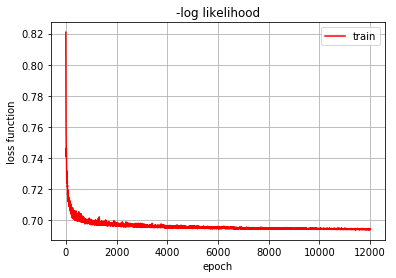

In [11]:
plt.plot(cost_train, 'r-', label='train')
# plt.plot(cost_test, 'g-', label='test')
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.title('-log likelihood')
plt.legend()
plt.grid()
plt.show()

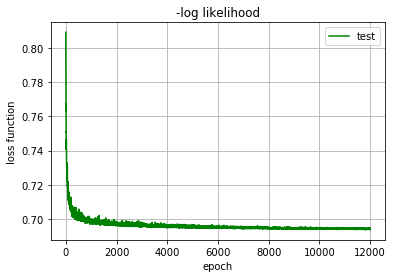

In [12]:
# plt.plot(cost_train, 'r-', label='train')
plt.plot(cost_test, 'g-', label='test')
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.title('-log likelihood')
plt.legend()
plt.grid()
plt.show()

In [13]:
def generate_image(occlud):
    
    generated_image = np.copy(occlud)
    
    for order in range(number_generate):
        count = height_occlud * width
        for h in range(height_occlud,height):
            for w in range(width):
                generate_pixel = sess.run(scaled_predict,feed_dict = {X: generated_image[order].reshape([1,-1])})
                generated_image[order,count] = generate_pixel[count]
                count += 1
            
    return generated_image

In [14]:
# generate

test_data = mnist.train.next_batch(number_generate)[0]

# original image
original = test_data
original = original.reshape((number_generate,height,width,1))

# occluded image
occlud = np.copy(test_data)
occlud[:, height_occlud * width : height * width] = 0
occlud = occlud.reshape((number_generate,height,width,1))
o = occlud.reshape((number_generate, height * width))

y_occlud = generate_image(o)    # completed images

In [15]:
improve_generated_image = np.copy(y_occlud)

def improve(old_value, old_min, old_max, new_min, new_max):
#     new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    new_value = ( (old_value - old_min) / (old_max - old_min + 0.000001) )
    return new_value

for i in range(number_generate):
    count = height_occlud * width
    half = improve_generated_image[i, height_occlud * width:] # for improving generated parts
    old_min, old_max, new_min, new_max = np.min(half), np.max(half), 0, 1
    
    for h in range(height_occlud,height):
        for w in range(width):
            improve_generated_image[i,count] = improve(improve_generated_image[i,count],
                                                       old_min, old_max, new_min, new_max)
            count += 1

In [16]:
# show:

original_image = np.empty((height, width * number_generate))
occluded_image = np.empty((height, width * number_generate))
predicted_image = np.empty((height, width * number_generate))
improve_predicted_image = np.empty((height, width * number_generate))
            
for i in range(number_generate):
    original_image[0:height,i*width:(i+1)*width] = original[i].reshape([height,width])
    occluded_image[0:height,i*width:(i+1)*width] = occlud[i].reshape([height,width])
    predicted_image[0:height,i*width:(i+1)*width] = y_occlud[i].reshape([height,width])
    improve_predicted_image[0:height,i*width:(i+1)*width] = improve_generated_image[i].reshape([height,width])

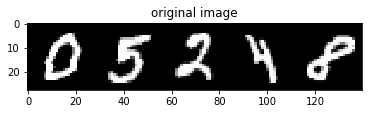

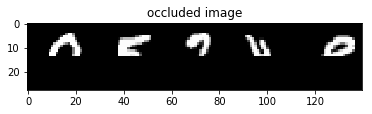

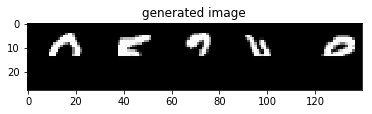

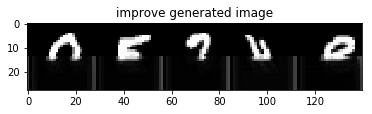

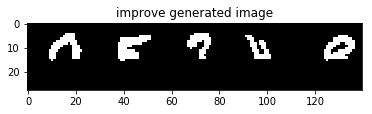

In [17]:
plt.imshow(original_image, cmap="gray")
plt.title("original image")
plt.show()

plt.imshow(occluded_image, cmap="gray")
plt.title("occluded image")
plt.show()

plt.imshow(predicted_image, cmap="gray")
plt.title("generated image")
plt.show()

plt.imshow(improve_predicted_image, cmap="gray")
plt.title("improve generated image")
plt.show()

plt.imshow(improve_predicted_image>0.5, cmap="gray")
plt.title("improve generated image")
plt.show()